created by Corinne Orton 4-12-25.
Run different evaluations, using code defined in "understanding how dr tools work..."

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
from evaluation import *
# might need to import run_script from this link?? found it in github comments
# https://github.com/mamba-org/mamba/blob/main/libmamba/src/core/link.cpp#L314

## load data ##

### CAFs ###

In [3]:
path = '/Users/corinne/Documents/GitHub/honors/HowUMAPWorks-master/'
expr = pd.read_csv(path + 'data/bartoschek_filtered_expr_rpkm.txt', sep='\t')
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

This data set contains 716 samples

Dimensions of the  data set: 
(716, 557) (716,)


### RNA mix 1 ###

In [127]:
path = '/Users/corinne/Documents/GitHub/honors/HowUMAPWorks-master/'
expr = pd.read_csv(path + 'data/RNAMix1Basic.csv', header=None)
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,:].T
X_train = np.log(X_train + 10) # + 10 to offset negative values and not get nans (min is around -9. something)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = pd.read_csv(path + 'data/RNAMix1Labels.csv', header=None)
y_train = y_train.iloc[:, 0].to_numpy() # need this for some reason, not sure why
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

           0         1         2         3
0  10.935506 -0.610733 -0.392360 -0.360941
1  -1.684056 -0.510148  0.045495  0.066115
2  -2.611871  2.666472 -1.241861 -0.998568
3   1.119148  0.970372 -0.683356 -0.636613

This data set contains 296 samples

Dimensions of the  data set: 
(296, 40) (296,)


### RNA mix 2 ###

In [58]:
path = '/Users/corinne/Documents/GitHub/honors/HowUMAPWorks-master/'
expr = pd.read_csv(path + 'data/RNAMix2Basic.csv', header=None)
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,:].T
X_train = np.log(X_train + 9) # min around -3.51
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = pd.read_csv(path + 'data/RNAMix2Labels.csv', header=None)
y_train = y_train.iloc[:, 0].to_numpy() # need this for some reason, not sure why
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

          0         1         2         3
0  9.446989 -0.110685 -0.063227 -0.049364
1 -1.956650 -0.424075 -0.554704 -0.500146
2 -1.727974  0.944490 -1.274324 -1.493488
3  1.517122 -0.443720 -0.863352 -0.879373

This data set contains 340 samples

Dimensions of the  data set: 
(340, 40) (340,)


### Cell Mix ###

In [38]:
path = '/Users/corinne/Documents/GitHub/honors/HowUMAPWorks-master/data/'
expr = pd.read_csv(path + 'CellMixSCT.csv', header=None)
print(expr.iloc[0:4,0:4])
print(X_train.shape)
X_train = expr.values[:,:].T
X_train = X_train[::4,:] # subsample of 980
X_train = np.log(X_train + 1) 
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = pd.read_csv(path + 'CellMixLabels.csv', header=None)
y_train = y_train.iloc[:, 0].to_numpy()
y_train = y_train[::4,] # subsample of 980
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

          0         1         2         3
0  0.016003  0.016001  0.015999  0.015993
1  0.001166  0.002862 -0.033287  0.002487
2 -0.018923 -0.018637  0.005579 -0.018075
3  0.033108  0.031323 -0.000531  0.030035
(980, 40)

This data set contains 980 samples

Dimensions of the  data set: 
(980, 40) (980,)


### load tensor ###

In [6]:
tensor = np.load("random_init_plots/CellMix embeddings/CellMix980_tsne_tensor.npy")
print(tensor.shape)

(5, 980, 2)


### load embedding ###

In [65]:
#embedding = np.load("pca_init_plots/cell mix/cell980_umap.npy")
embedding = np.load("concat_embeds/Cell980 0.75.npy")
print(embedding.shape)

(980, 2)


## Random Triplet Accuracy ##

### non tensor ###

In [66]:
rt_acc = np.zeros(5,)
for i in range(5):
    rt_acc[i] = random_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
# round to 4 decimals
print (f"{np.mean(rt_acc):.4f}", "&", f"{np.std(rt_acc):.4f}") # latex format

0.5479 & 0.0021


### tensor ###

In [304]:
n = 20 # num_embeddings
rt_acc = np.zeros((n,5)) # num_embeddings x num_triplets
for i in range(n):
    embedding = tensor[i,:,:]
    for j in range(5):
        rt_acc[i,j] = random_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
print (f"{np.mean(rt_acc):.4f}", "&", f"{np.std(rt_acc):.4f}") # latex format

0.8000 & 0.0157


## Centroid Triplet Accuracy ##

### tensor ###

In [15]:
n = 5 # num_embeddings
centr_acc = np.zeros(n,)  
for i in range(n):
    embedding = tensor[i,:,:]
    centr_acc[i] = centroid_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
print (f"{np.mean(centr_acc):.4f}")

0.6057


### non tensor ###

In [67]:
centr_acc = centroid_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
print (f"{centr_acc:.4f}")

0.2222


## kNN ##

### non tensor ###

In [68]:
knn_arr = knn_eval_series(embedding, y_train, n_neighbors_list=[1,3,5,10,15,20])
print(" & ".join(map(str, np.around(knn_arr,4))))

0.9684 & 0.9755 & 0.9745 & 0.9735 & 0.9755 & 0.9745


### tensor ###

In [306]:
n = 20
knn_arr = np.zeros((n,6))
for i in range(n): # num embeddings stored in tensor
    knn_arr[i,:] = knn_eval_series(tensor[i,:,:], y_train, n_neighbors_list=[1,3,5,10,15,20])
knn_arr = np.mean(knn_arr, axis=0)
print(" & ".join(map(str, np.around(knn_arr,4))))

0.9867 & 0.9874 & 0.9879 & 0.9878 & 0.9841 & 0.9819


In [261]:
# bigger neighborhood knn for cell mix specifically
n = 20
knn_arr = np.zeros((n,6))
for i in range(n): # num embeddings stored in tensor
    knn_arr[i,:] = knn_eval_series(tensor[i,:,:], y_train, n_neighbors_list=[25, 30, 40, 50, 75, 100])
knn_arr = np.mean(knn_arr, axis=0)
print(" & ".join(map(str, np.around(knn_arr,4))))

0.9402 & 0.9339 & 0.9012 & 0.8947 & 0.8569 & 0.8145


## overall structure ##

In [69]:
#mean_rt = 0.6163
#mean_rt = np.mean(rt_acc)
# use centroid triplet instead - Corinne 4-21
overall = (np.array(knn_arr) + centr_acc)/2
print(" & ".join(map(str, np.around(overall,4))), "&", "\\textbf{"+f"{np.mean(overall):.4f}"+"}")

0.5953 & 0.5989 & 0.5984 & 0.5978 & 0.5989 & 0.5984 & \textbf{0.5979}


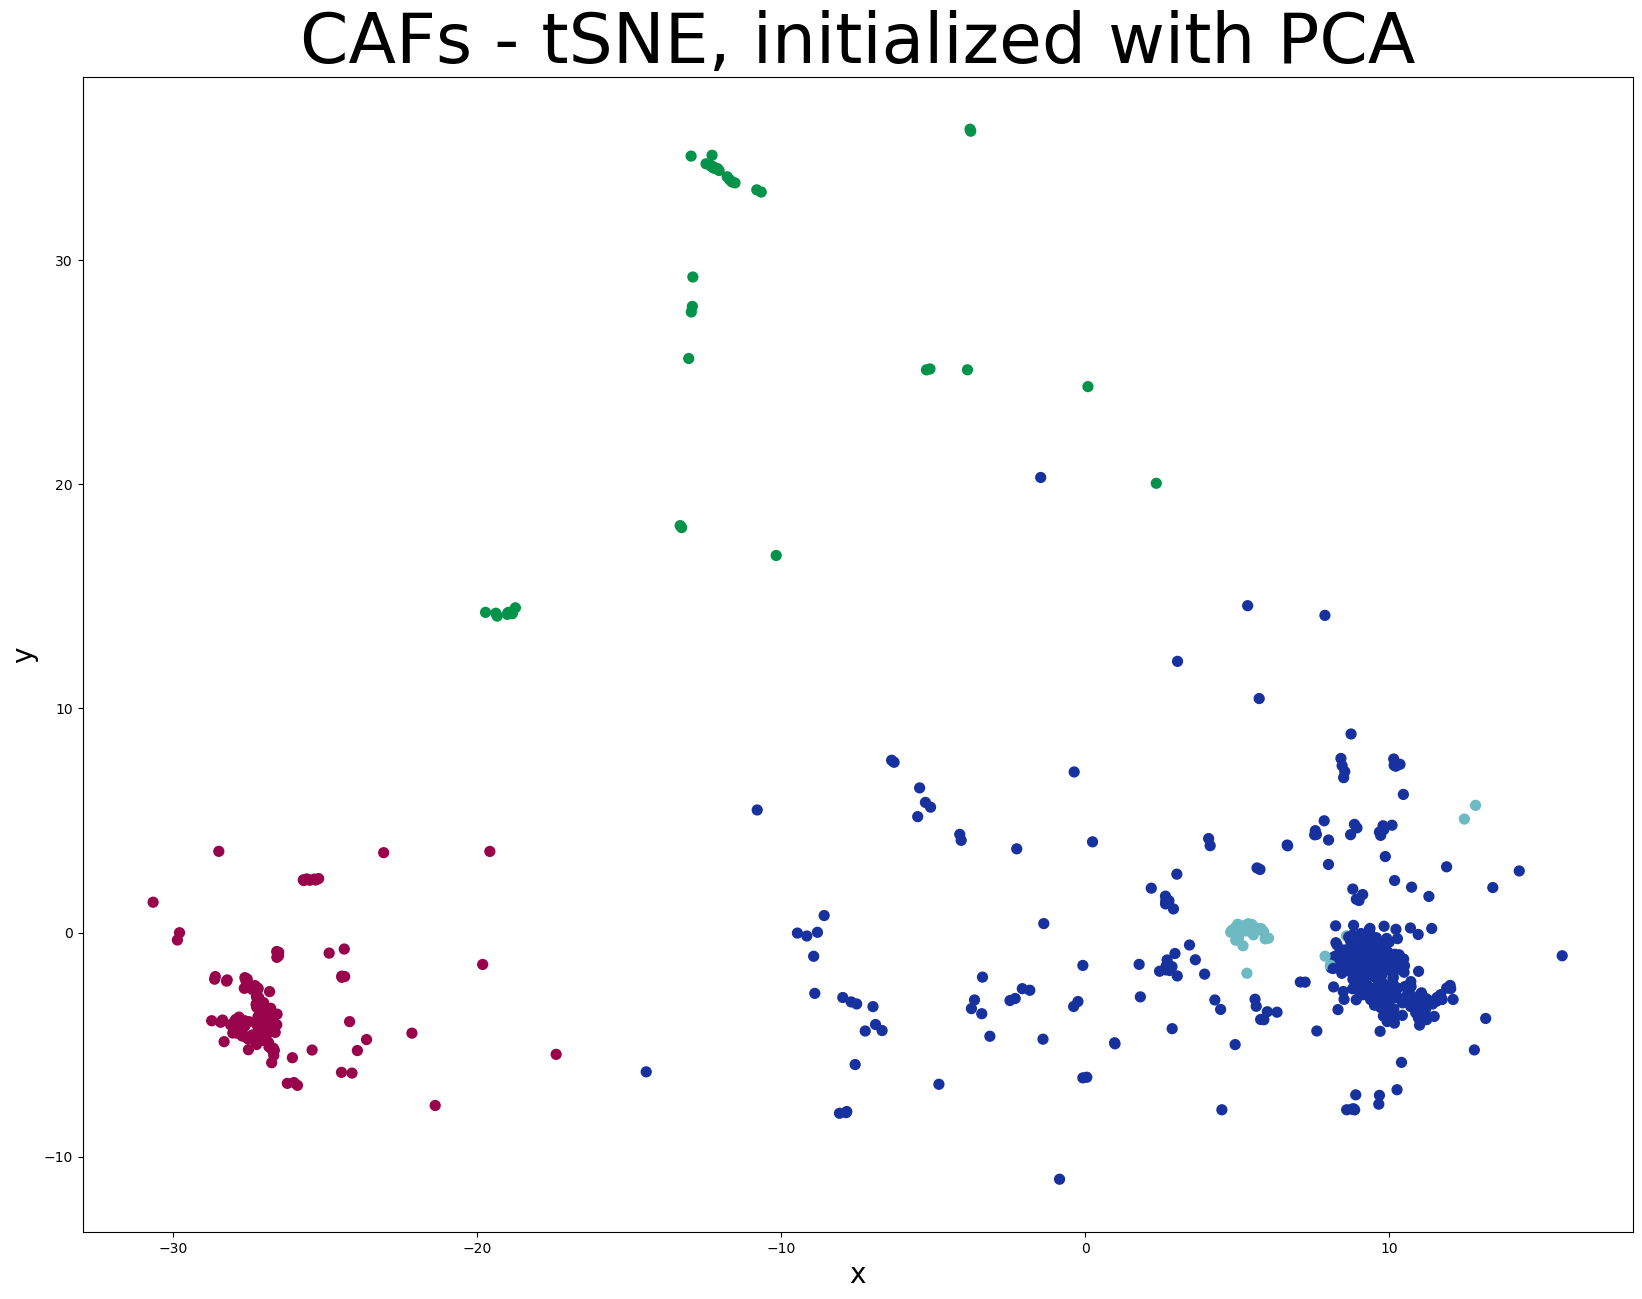

In [100]:
#y = tensor[0]
y = embedding
plt.figure(figsize=(20,15))
#colors = ['#0517b3','#b16ce6','#03934a','#36b4f7','#980503'] # cell mix
colors = ['#17329f','#98034c','#03934a','#6ebac3'] # CAFs
mapped_colors = [colors[int(value-1)] for value in y_train]
plt.scatter(y[:,0], y[:,1], s = 50, c=mapped_colors)
#plt.scatter(y[:,0], y[:,1], s = 50, c=y_train, cmap='tab10') # RNA
# tSNE_PCA: \u03B1 = 0.75
plt.title("CAFs - tSNE, initialized with PCA", fontsize = 50)
plt.xlabel("x", fontsize = 20); plt.ylabel("y", fontsize = 20)
plt.show()
